# <span style='font-family:"serif"'><font color='k'>Inflow with Ram Pressure Stripping</font>

#### <span style='font-family:"serif"'> The main version of the Inflow with Ram Pressure Stripping model (IRPS) and its gas-$\alpha$-abundance equations are here. I showed models for the range of [$\alpha$/H]$_{s}$, $\xi$ and $\zeta$ as examples.</font>

#### <span style='font-family:"serif"'> This notebook is a simplified tutorial, from which you will learn:</font>
#### <span style='font-family:"serif"'> -- how &alpha;-abundance distribution function (ADF) of IRPS model looks like</font>

#### <span style='font-family:"serif"'> -- how this ADF uses gas as abundance-dependent function and how they are constructed</font>

#### <span style='font-family:"serif"'> -- you will learn how to build this GCE-model for different parameters</font>

* #### <span style='font-family:"serif"'>numpy - used for numpy.arrays and conditional usage of indexes</font>
* #### <span style='font-family:"serif"'>scipy.special - the gas-metallicity equations has hypergeometrical and exponential functions in them</font>
* #### <span style='font-family:"serif"'>matplotlib.pyplot - for visualization</font>

In [1]:
import numpy as np
from   scipy.special import hyp2f1, expi
import matplotlib.pyplot as plt


def format_ticks():
    '''
    This function is for figure formatting
    '''
    plt.rcParams.update({'font.family': 'DeJavu Serif'})
    plt.rcParams.update({'font.serif':'Times New Roman'})
    plt.gca().tick_params(which='major', direction="in", length=5.,\
                        labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                        bottom=True, top=True, left=True, right=True)
    plt.gca().tick_params(which='minor', direction="in", length=3.,\
                        labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                        bottom=True, top=True, left=True, right=True)

## <span style='font-family:"serif"'>Main functions</font>

>### <span style='font-family:"serif"'><font color='k'> Part 1: gas--$\alpha$-abundance relations</font>

#### <span style='font-family:"serif"'> This cell contains functions to build gas-abundance relation: _eq_before_g_, _eq_after_g_abs_, _eq_after_g_equal_ build Z(g) before the forced _gas_ loss occured (Z<sub>1</sub>(g) corresponds to "Before RPS" (ram pressure stripping)), and after (for &xi; != &zeta; and &xi; == &zeta; respectively; note, that &xi; parameter I write everywhere as _F_, &zeta; parameter I write as _E_ or _Es_; Z<sub>2</sub>(g) corresponds to "After RPS"). </font>
#### <span style='font-family:"serif"'> To merge them into a single solution, the initial conditions for equation(s) "After RPS" are replaced with RPS-value obtained from parameter [&alpha;/H]<sub>str</sub> and corresponding gas fraction point obtained with function _g_rps_.</font>
#### <span style='font-family:"serif"'> _long_coef_ is a part of the expression for Z<sub>2</sub>(g) ("After RPS") with &xi; != &zeta;.</font>

#### <span style='font-family:"serif"'> _gas_equation_ combines above formulae and returns gas for equally spaced N = _points_ alpha abundances within [&alpha;/H]<sub>min</sub>=-5, [&alpha;/H]<sub>max</sub>=0</font>

#### <span style='font-family:"serif"'> There are solutions Z(g) which on g-log(Z) plot are convex. It depends on g-&xi;, g-(&xi;-&zeta;) signs: if gas is below than the normalized inflow, the function is monotonic, but if less, the ([&alpha;/H], g) plot will contain two "branches", upper, with gas decrease for &alpha;-abundance increase, and lower branch, where the gas decreases for &alpha;-abundance decrease. In this situation I chose "upper" branch, while fixation of inflow after [&alpha;/H]<sub>str</sub> for some minimal value also decreases the significance of the lower branch. Figure 1, green dashed line illustrates this point: the turning point is almost at g = 0.

In [2]:
def eq_before_g(F, z_inflow, z_initial, g, g_in = 1.):
    
    '''
        Determines z' = Z/p_eff = (10^[alpha/H])/p_eff 
    for array of g using equation "Before RPS"
    (where p_eff = p/(1+eta) - effective yield)
    ------
    Input:
    ------
    F            normalized inflow, xi
    z_inflow     alpha-abundance of inflow, expressed as z'_inflow
    z_initial    initial alpha-abundance, for z'_initial
    g            array of g values
    g_in         initial fraction of gas. We assumed that galaxy has started as cloud of gas: g_in=1
    ------
    Returns:
    ------
    z            array of z' values
    '''
    
    z = np.full(len(g), -np.inf)
    
    if F!=g_in:
        i = np.where((((F-g)/(F-g_in)>0) & (g!=0.)))[0]
        z[i] = g_in*(F-g[i])/g[i]/(F-g_in)*z_initial+\
                (F-g[i])/g[i]*(np.log(((F-g[i])/(F-g_in)))) +\
               F*(g[i]-g_in)/g[i]/(F-g_in)*(z_inflow+1)
    return z

def g_rps(F, z_inflow, z_initial, z_str):
    
    '''
        Determines gas fraction in units of initial galaxies' mass
    at moment when RPS commences, associated with [alpha/H]=[alpha/H]_s.
    ------
    Input:
    ------
    F            normalized inflow, xi
    z_inflow     alpha-abundance of inflow, expressed as z'_inflow
    z_initial    initial alpha-abundance, for z'_initial
    z_str        alpha-abundance by achieving which RPS begins, z'_str
    ------
    Returns:
    ------
    g_str        gas fraction at z' = z'_str = (10^[alpha/H]_s)/p_eff
    '''
    
    g = np.linspace(0., F*1.9999, 1000)
    z = eq_before_g(F, z_inflow, z_initial, g)
    z[np.where(np.isnan(z))] = -np.inf
    delta = np.min(abs(z-z_str))
    
    if z.max()>z_str:
        g_str = g[np.where(abs(z-z_str)==delta)]
        if isinstance(g_str, list) or isinstance(g_str, np.ndarray):
            g_str = g_str[0]
    else:
        g_str = F*.9999
    
    return g_str

def long_coef(F, Es, z_inflow, z_initial, g_in=1.):
    
    '''
        Supplemental function for equation z'(g) after RPS has started.
    ------
    Input:
    ------
    F            normalized inflow, xi
    Es           normalized forced gas outflow, zeta
    z_inflow     alpha-abundance of inflow, expressed as z'_inflow
    z_initial    initial alpha-abundance, for z'_initial
    g_in         initial fraction of gas
    ------
    Returns:
    ------
    Constant term for equation z'(g) after RPS if F!=Es.
    '''
    
    return ((g_in/F+(Es-F)/F)*hyp2f1(1,1,F/(F-Es)+1, g_in/(F-Es))+(F-Es)/F+z_inflow-z_initial)

def eq_after_g_abs(F, Es, z_inflow, z_initial, long_coef, g, g_in=1.):
    
    '''
       Determines z' = Z/p_eff = (10^[alpha/H])/p_eff for 
    array of g using equation "After RPS" where F != Es
    (where p_eff = p/(1+eta) - effective yield).
    ------
    Input:
    F            normalized inflow, xi
    Es           normalized forced gas outflow, zeta
    z_inflow     alpha-abundance of inflow, expressed as z'_inflow
    z_initial    initial alpha-abundance, for z'_initial
    long_coef    constant value (see long_coef() function)
    g            array of g values
    g_in         gas at beginning of RPS epoch, g_stripped
    ------
    Returns:
    z            array of z' values: len(z)=len(g)
    '''
    return -np.power(g*(g_in-F+Es)/(g_in*(g-F+Es)), F/(Es-F))*long_coef + \
            1/F*(g-F+Es)*hyp2f1(1,1,F/(F-Es)+1, g/(F-Es)) + (F-Es)/F+z_inflow
    
def eq_after_g_equal(F, z_inflow, z_initial, g, g_in):
    
    '''
       Determines z' = Z/p_eff = (10^[alpha/H])/p_eff for 
    array of g using equation "After RPS" where F = Es
    (where p_eff = p/(1+eta) - effective yield).
    ------
    Input:
    F            normalized inflow xi
    z_inflow     alpha-abundance of the inflow expressed as z'_inflow
    z_initial    initial alpha-abundance for z'_initial
    g            array of g values
    g_in         initial fraction of gas
    ------
    Returns:
    z            array of z' values: len(z)=len(g).
    '''
    
    return np.exp(-F*(1./g-1./g_in))*(z_initial-z_inflow) + \
           np.exp(-F/g)*(expi(F/g)-expi(F/g_in)) + z_inflow

def gas_equation(p_eff, F, Es, aH_inflow, aH_initial, aH_str, points = 5001, show=True):
    
    '''
       Function to determine g(z').
    ------
    Input:
    ------
    p_eff        effective yield in Solar metallicity units
    F            normalized inflow, xi
    Es           normalized forced gas outflow, zeta
    aH_inflow    alpha-abundance of inflow
    aH_initial   initial alpha-abundance
    aH_str       alpha-abundance at moment when RPS begins
    points       length of returned g array
    show         show the figure of g([alpha/H])
    ------
    Returns:
    ------
    g([alpha/H])   gas as a function of alpha-abundance
    '''
    
    # Determine two z'(g) (before and after RPS) separately.
    # Then consider only parts which are required to construct final g(z')
    arr = 1000
    
    z_inflow  = (10**aH_inflow)/p_eff
    z_initial = (10**aH_initial)/p_eff
    z_str     = (10**aH_str)/p_eff
    
    # If xi<1, g will decrease with [alpha/H] for [alpha/H]<[alpha/H]_s
    if F<1:  loss = True;  g_max = 1.
    else:    loss = False; g_max = 1.9999*F
    
    g    = np.linspace(0, g_max, arr)
    
    # Initial gas g_in of equation "After RPS":
    g_str = g_rps(F, z_inflow, z_initial, z_str)

    # "After RPS" inflow xi:
    F2 = 0.01
    
    # Derive long_coef for "After RPS" equation
    if F2!=Es:
        coef_here = long_coef(F2, Es, z_inflow, z_str, g_str)
    
    # Calculate z'(g) from "Before RPS"
    z_before = eq_before_g(F, z_inflow, z_initial, g)
    
    # If xi>1, and if p_eff is very small, g achieves xi at max(z_before) << z_str,
    # which from Extreme Inflow model of Larson (1986) balances gas loss with gas inflow
    # and makes further increase of alpha-abundance impossible:
    if np.max(z_before[np.where(np.isfinite(z_before))])<z_str:
        return
    
    z_after = []
    
    # Calculate z'(g) from "After RPS".
    for i in range(len(g)):
        if F2==Es:
            z_after.append(eq_after_g_equal(F2, z_inflow, z_str, g[i], g_str))
        else:
            z_after.append(eq_after_g_abs(F2, Es, z_inflow, z_str, coef_here, g[i], g_str))
    
    z_before = np.array(z_before)
    z_after  = np.array(z_after)
    
    z_before, g_before = z_before[np.where(np.isfinite(z_before) & (z_before>0))], g[np.where(np.isfinite(z_before) & (z_before>0))]
    aH_before         = np.log10(z_before*p_eff)
    z_after,  g_after  = z_after[np.where(np.isfinite(z_after) & (z_after>0))   ], g[np.where(np.isfinite(z_after) & (z_after>0))]    
    
    # z'(g) for "After RPS" with Es>F2 is convex function.
    # On g(z') plot, let's consider it as two branches, upper and lower.
    # for upper branch  z' increases with gas decrease
    # for lower branch  z' decreases with gas decrease
    # Conditions for IRPS usage were determined to exclude that (lower) metal-poor branch:
    z_max    = z_after.max()
    z_after0 = z_after
    g_after0 = g_after
    
    g_edge = g_after[np.where(z_after==z_max)]
    
    z_after, g_after = z_after[np.where(g_after>g_edge)], g_after[np.where(g_after>g_edge)]
    aH_after        = np.log10(z_after*p_eff)
    
    # In both cases g increments. If loss==True or Es>F2, [alpha/H] will 
    # decrease. To recover order arrays must be flipped as follows
    if loss:
        aH_before, g_before = np.flip(aH_before), np.flip(g_before)
    if loss or Es>=F2:
        aH_after,  g_after  = np.flip(aH_after),  np.flip(g_after)
    
    g_f   = g_before[np.where(aH_before<=aH_str)]
    aH_f = aH_before[np.where(aH_before<=aH_str)]
    g_f   = np.append(g_f,     g_after[np.where(aH_after>aH_str)])
    aH_f = np.append(aH_f, aH_after[np.where(aH_after>aH_str)])
    
    if show:
        plt.plot(aH_before, g_before, color='blue',  linestyle='dashed', label='g([alpha/H])\nBefore RPS')
        plt.plot(np.log10(z_after0*p_eff), g_after0, color='y', linestyle='dashed', label='After RPS (all)')
        plt.plot(aH_after,  g_after, color='green', linestyle='solid', lw=0.5, label='After RPS')
        plt.ylim([-2.5, F*1.1])
        plt.xlim([-5., 0.])
    
    g_f, aH_f = g_f[np.where((np.isfinite(g_f) & np.isfinite(aH_f) & (aH_f<5.)))],\
               aH_f[np.where((np.isfinite(g_f) & np.isfinite(aH_f) & (aH_f<5.)))]
    
    aH_min_1 = np.min(aH_before)
    aH_max_1 = np.max(aH_after)
    
    # Interpolate for equally spaced [alpha/H] values.
    # Absent pieces are fulfilled with g=1, g=0 for beginning and end of 
    # evolution, if needed
    alphah = np.linspace(-5., 0., points)
    gas = np.interp(alphah, aH_f, g_f)
    gas[np.where(alphah<aH_min_1)] = 1.
    
    if aH_max_1 < 0.:
        gas[np.where(alphah>=aH_max_1)] = 0.
    
    if show:
        plt.plot(aH_f, g_f, color = 'cyan', linestyle='solid', label = 'Construct' )
        plt.plot(np.linspace(-5., 0., points), gas, color = 'k', linestyle='dotted', label = 'Interpolated')
        plt.xlabel("[alpha/H]")
        plt.ylabel("Gas")
    
    return gas

>### <span style='font-family:"serif"'><font color='k'>Part 2: IRPS model </font>

#### <span style='font-family:"serif"'> The &alpha;-element distribution function (ADF) of IRPS model you can find from _a2()_ function. For the input, the _gas_ points should be predetermined for each of _alphaH_ points from _gas_equation_ function. Keep in mind that _alphaH_ is between -5 and 0 with length _points_ points (argument of _gas_equation_ function)</font> 

In [3]:
def a2(p, aH_f, F, E, alphah, gas, aH_str, show=False):
    
    '''
       The IRPS model (which sometimes I refer as Accretion-2, A2).
    ------
    Input:
    ------
    p           effective yield in Solar metallicity units
    aH_f        alpha-abundance of inflow
    F           normalized inflow xi
    E           normalized forced gas outflow zeta'_s
    alphah      array of [alpha/H] where the alpha-abundance distribution function should be calculated
    gas         array of gas points for each [alpha/H]
    aH_str      alpha-abundance at the moment when RPS begins, aH_s
    ------
    Returns:
    ------
    r([alpha/H])    Model points.    
    '''
    
    l = None
    if isinstance(gas, float):
        gas = np.array([gas])
        alphah = np.array([alphah])
        l = 1.
        
    r = np.zeros(len(gas))
    ph1 = np.where(((gas!=0)&(alphah<=aH_str)))[0]
    ph2 = np.where(((gas!=0)&(alphah>aH_str)))[0]
    
    r[ph1] = (10**alphah[ph1])*gas[ph1]/p/(1+(10.**aH_f-10.**alphah[ph1])/p*F/gas[ph1])
    r[ph2] = (10**alphah[ph2])*gas[ph2]/p/(1+(10.**aH_f-10.**alphah[ph2])/p*0.01/gas[ph2])
    
    r[np.where(r<0.)] = 0.
    if isinstance(l, float):
        r = r[0]
        show = False
    
    if show:
        p = plt.plot(alphah, gas, ls = 'dotted', label='Gas')
        c = p[0].get_color()
        plt.plot(alphah, r, c=c, ls = 'solid', lw=0.75, label = "ADF: \u03BE"+f'={F}, '+'[alpha/H]$_s$'+f'={aH_str}, '+'\u03B6'+f'={E}')
        plt.xlabel("[alpha/H]")
        plt.ylabel("ADF")
        
    return r

## <span style='font-family:"serif"'>Examples: fitting [&alpha;/H]<sub>str</sub>, p<sub>eff</sub>, &zeta;/&xi; for IRPS ADF

>### <span style='font-family:"serif"'><font color='k'> Prompt values for g([$\alpha$/H]), $\alpha$-elements Distribution Function (ADF) </font>

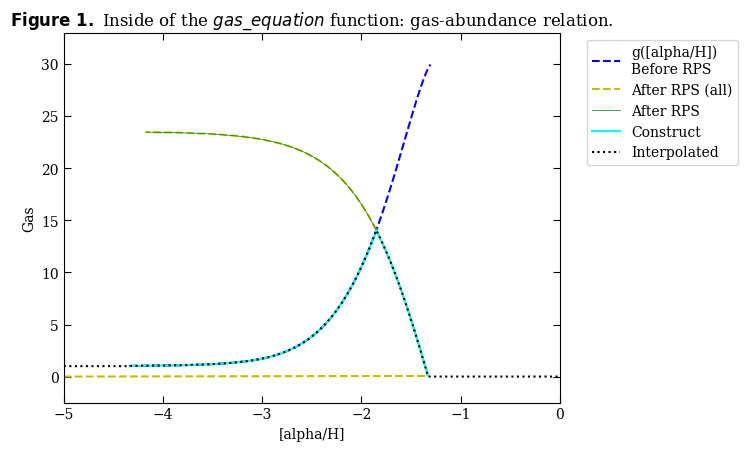

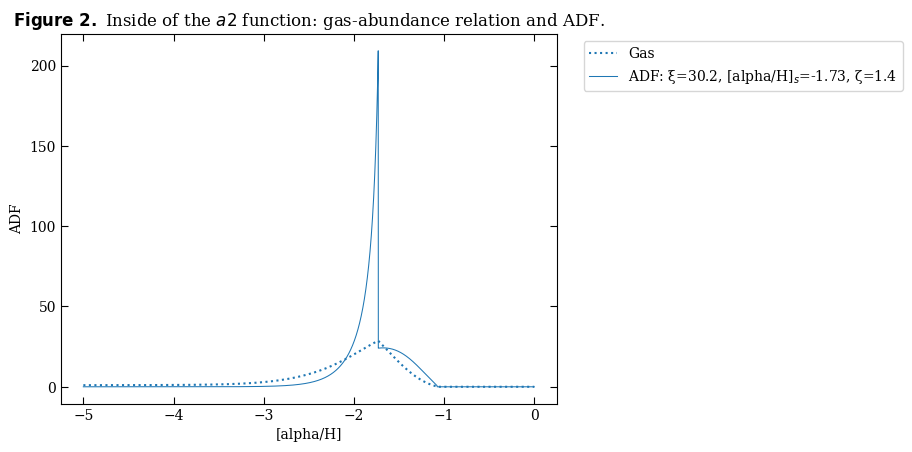

In [4]:
alphah = np.linspace(-5., 0., 5001)
p = 0.0222; F = 30.2; E = 1.4; aH_str = -1.73

format_ticks()
gas2 = gas_equation(0.05, 30.01, 15., -5, -5, aH_str=-1.85, points=5001, show=True);
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
plt.title(r"$\mathbf{Figure~1.}$ Inside of the $\mathit{gas \_ equation}$ function: gas-abundance relation.");
plt.show()

format_ticks()
a2(p, -5., F, E, alphah, gas_equation(p, F, E, -5, -5, aH_str, 5001, show=False), aH_str = aH_str, show=True);
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
plt.title(r"$\mathbf{Figure~2.}$ Inside of the $\mathit{a2}$ function: gas-abundance relation and ADF.");

In [5]:
# Try it

>### <span style='font-family:"Georgia"'><font color='k'> Example #1: $\alpha$-abundance of ram pressure stripping [$\alpha$/H]$_s$ </font>

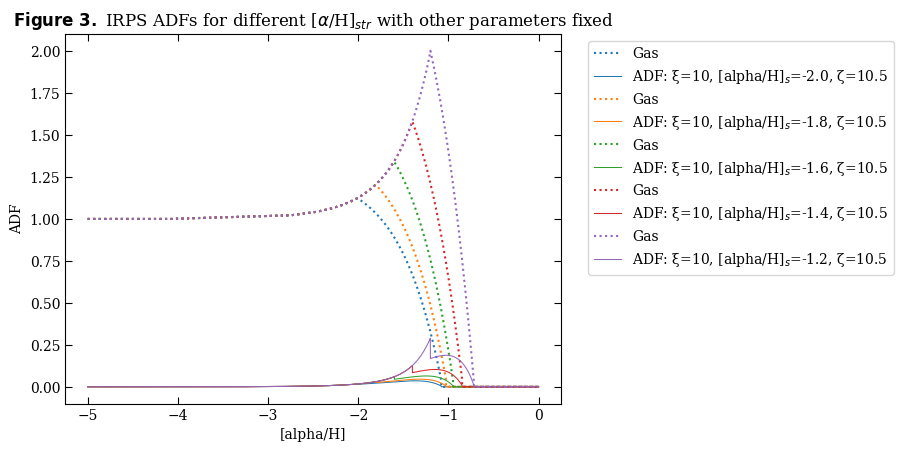

In [6]:
p = 0.75; F = 10; E = 10.5; aH_str = -1.3; alphah = np.linspace(-5., 0., 5001)

format_ticks()
for fs in range(-20, -11, 2):
    a2(p, -5., F, E, alphah, gas_equation(p, F, E, -5, -5, fs/10., show=False), aH_str = fs/10.,\
               show=True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(r"$\mathbf{Figure~3.}$ IRPS ADFs for different [$\alpha$/H]$_{str}$ with other parameters fixed");
plt.show()

In [7]:
# Try it

>### <span style='font-family:"serif"'><font color='k'> Example #2: inflow $\xi$ </font>

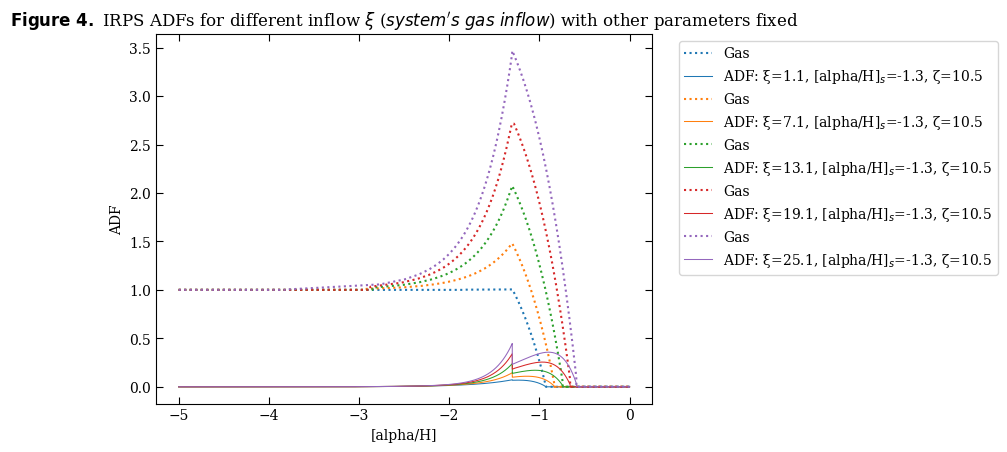

In [8]:
p = 0.75; F = 10; E = 10.5; aH_str = -1.3; alphah = np.linspace(-5., 0., 5001)

format_ticks()
for f in range(11, 300, 60):
    a2(p, -5., f/10., E, alphah, gas_equation(p, f/10., E, -5, -5, aH_str, show=False), aH_str = aH_str,\
               show=True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(r"$\mathbf{Figure~4.}$ IRPS ADFs for different inflow $\xi$ ($\mathit{system's~gas~inflow}$) with other parameters fixed");
plt.show()

In [9]:
# Try it too

>### <span style='font-family:"serif"'><font color='k'> Example #3.1: terminal wind rate $\zeta$ </font>

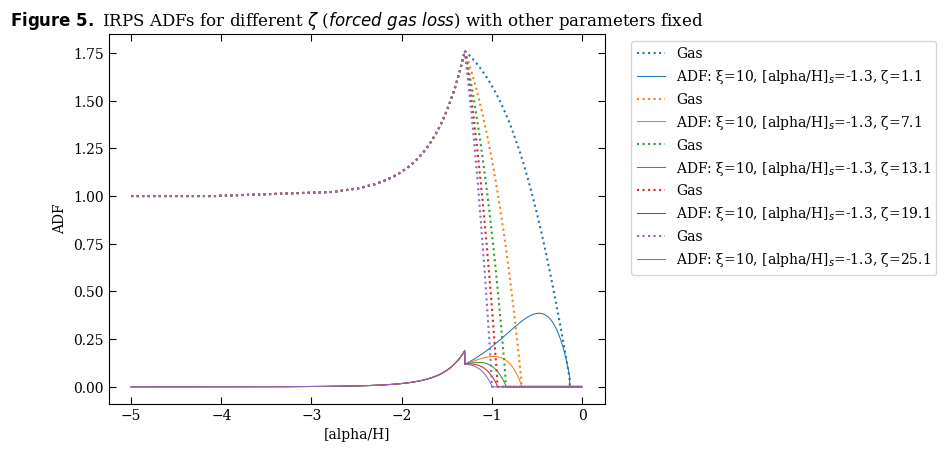

In [10]:
p = 0.75; F = 10; E = 10.5; aH_str = -1.3; alphah = np.linspace(-5., 0., 5001)

format_ticks()
for e in range(11, 300, 60):
    a2(p, -5., F, e/10., alphah, gas_equation(p, F, e/10., -5, -5, aH_str, show=False), aH_str = aH_str,\
               show=True)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title(r"$\mathbf{Figure~5.}$ IRPS ADFs for different $\zeta$ ($\mathit{forced~gas~loss}$) with other parameters fixed");
plt.show()

In [11]:
# Try it

## <span style='font-family:"serif"'><font color='k'> About this notebook </font>

#### <span style='font-family:"serif"'><font color='k'> In case of question, contact kkvasova@nd.edu </font>

## <span style='font-family:"serif"'><font color='k'> Citations </font>

#### <span style='font-family:"serif"'><font color='k'>  If you use `numpy`, `scipy`, `matplotlib` for published research, please cite the authors. Follow these links for more information about citing: </font>

* #### <span style='font-family:"serif"'><font color='k'>  [Citing `numpy`](https://numpy.org/citing-numpy/) </font>
* #### <span style='font-family:"serif"'><font color='k'>  [Citing `scipy`](https://scipy.org/citing-scipy/) </font>
* #### <span style='font-family:"serif"'><font color='k'>  [Citing `matplotlib`](https://matplotlib.org/stable/project/citing.html) </font>